In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if device.type == 'cuda':
    torch.cuda.manual_seed(seed)


Using device: cuda


100%|██████████| 170M/170M [00:04<00:00, 40.9MB/s] 


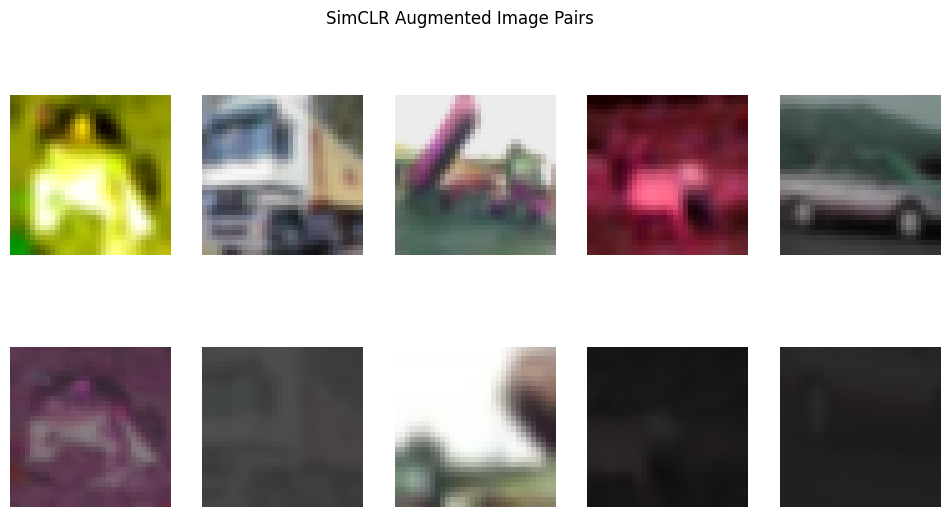

In [4]:
Dataset and Augmentations

# SimCLR augmentation pipeline for CIFAR-10 (32x32 images)
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=32, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
])

# Custom Dataset to return two augmented versions of same image as per SimCLR
class SimCLRDataset(datasets.CIFAR10):
    def __getitem__(self, index):
        img, _ = super().__getitem__(index)
        xi = simclr_transform(img)
        xj = simclr_transform(img)
        return xi, xj

# Load dataset
train_dataset = SimCLRDataset(root='./data', train=True, download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2, drop_last=True)

# Visualize some augmented images pairs
def show_pairs(dataset, n=5):
    fig, ax = plt.subplots(2, n, figsize=(12,6))
    for i in range(n):
        x1, x2 = dataset[i]
        ax[0, i].imshow(x1.permute(1, 2, 0))
        ax[0, i].axis('off')
        ax[1, i].imshow(x2.permute(1, 2, 0))
        ax[1, i].axis('off')
    plt.suptitle('SimCLR Augmented Image Pairs')
    plt.show()

show_pairs(train_dataset, n=5)


In [5]:
Model Definition (ResNet18 + Projection Head)

from torchvision.models import resnet18

class SimCLR(nn.Module):
    def __init__(self, base_model=resnet18, out_dim=128):
        super(SimCLR, self).__init__()
        self.encoder = base_model(pretrained=False)
        self.encoder.fc = nn.Identity()  
        
        # Projection Head: 2-layer MLP as in SimCLR paper
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )
        
    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)       
        z = F.normalize(z, dim=1) 
        return z

model = SimCLR().to(device)
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


SimCLR(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [8]:
#NT-Xent Loss Implementation

class NTXentLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.similarity_function = nn.CosineSimilarity(dim=2)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        
        # Create mask to ignore similarity with self for negatives
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        self.register_buffer("mask", mask)
        
    def forward(self, z_i, z_j):
        N = 2 * self.batch_size
        
        z = torch.cat((z_i, z_j), dim=0)  
        
        # Compute similarity matrix
        sim = self.similarity_function(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        
        # Positive similarity is diagonal offset by batch_size
        positives = torch.cat([
            torch.diag(sim, self.batch_size),
            torch.diag(sim, -self.batch_size)
        ]).view(N, 1)
        
        # Mask out positives and self-similarities from negatives
        negatives = sim[self.mask].view(N, -1)
        
        labels = torch.zeros(N).to(device).long()
        
        logits = torch.cat((positives, negatives), dim=1)
        
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss


criterion = NTXentLoss(batch_size=256, temperature=0.5)


In [9]:
#Training Loop

optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)
epochs = 100  # research-grade, can be reduced for testing

def train_simclr(model, loader, optimizer, criterion, device, epochs):
    model.train()
    history = []
    
    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        for (x_i, x_j) in pbar:
            x_i, x_j = x_i.to(device), x_j.to(device)
            
            optimizer.zero_grad()
            z_i = model(x_i)
            z_j = model(x_j)
            loss = criterion(z_i, z_j)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pbar.set_postfix({"loss": total_loss/(pbar.n+1)})
        
        avg_loss = total_loss / len(loader)
        history.append(avg_loss)
        print(f"Epoch {epoch+1}: Avg Loss = {avg_loss:.4f}")
    
    return history

train_history = train_simclr(model, train_loader, optimizer, criterion, device, epochs)


Epoch 1/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 1: Avg Loss = 5.6445


Epoch 2/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 2: Avg Loss = 5.4418


Epoch 3/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 3: Avg Loss = 5.3693


Epoch 4/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 4: Avg Loss = 5.3077


Epoch 5/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 5: Avg Loss = 5.2708


Epoch 6/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 6: Avg Loss = 5.2363


Epoch 7/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 7: Avg Loss = 5.2118


Epoch 8/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 8: Avg Loss = 5.1938


Epoch 9/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 9: Avg Loss = 5.1754


Epoch 10/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 10: Avg Loss = 5.1602


Epoch 11/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 11: Avg Loss = 5.1483


Epoch 12/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 12: Avg Loss = 5.1423


Epoch 13/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 13: Avg Loss = 5.1277


Epoch 14/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 14: Avg Loss = 5.1200


Epoch 15/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 15: Avg Loss = 5.1074


Epoch 16/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 16: Avg Loss = 5.0985


Epoch 17/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 17: Avg Loss = 5.0934


Epoch 18/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 18: Avg Loss = 5.0836


Epoch 19/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 19: Avg Loss = 5.0764


Epoch 20/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 20: Avg Loss = 5.0720


Epoch 21/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 21: Avg Loss = 5.0647


Epoch 22/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 22: Avg Loss = 5.0557


Epoch 23/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 23: Avg Loss = 5.0472


Epoch 24/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 24: Avg Loss = 5.0453


Epoch 25/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 25: Avg Loss = 5.0391


Epoch 26/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 26: Avg Loss = 5.0365


Epoch 27/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 27: Avg Loss = 5.0296


Epoch 28/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 28: Avg Loss = 5.0262


Epoch 29/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 29: Avg Loss = 5.0158


Epoch 30/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 30: Avg Loss = 5.0179


Epoch 31/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 31: Avg Loss = 5.0120


Epoch 32/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 32: Avg Loss = 5.0063


Epoch 33/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 33: Avg Loss = 5.0020


Epoch 34/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 34: Avg Loss = 4.9997


Epoch 35/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 35: Avg Loss = 4.9937


Epoch 36/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 36: Avg Loss = 4.9897


Epoch 37/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 37: Avg Loss = 4.9860


Epoch 38/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 38: Avg Loss = 4.9828


Epoch 39/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 39: Avg Loss = 4.9773


Epoch 40/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 40: Avg Loss = 4.9743


Epoch 41/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 41: Avg Loss = 4.9695


Epoch 42/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 42: Avg Loss = 4.9675


Epoch 43/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 43: Avg Loss = 4.9630


Epoch 44/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 44: Avg Loss = 4.9575


Epoch 45/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 45: Avg Loss = 4.9572


Epoch 46/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 46: Avg Loss = 4.9573


Epoch 47/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 47: Avg Loss = 4.9517


Epoch 48/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 48: Avg Loss = 4.9482


Epoch 49/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 49: Avg Loss = 4.9452


Epoch 50/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 50: Avg Loss = 4.9455


Epoch 51/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 51: Avg Loss = 4.9427


Epoch 52/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 52: Avg Loss = 4.9386


Epoch 53/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 53: Avg Loss = 4.9355


Epoch 54/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 54: Avg Loss = 4.9316


Epoch 55/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 55: Avg Loss = 4.9295


Epoch 56/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 56: Avg Loss = 4.9282


Epoch 57/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 57: Avg Loss = 4.9203


Epoch 58/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 58: Avg Loss = 4.9209


Epoch 59/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 59: Avg Loss = 4.9207


Epoch 60/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 60: Avg Loss = 4.9203


Epoch 61/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 61: Avg Loss = 4.9147


Epoch 62/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 62: Avg Loss = 4.9122


Epoch 63/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 63: Avg Loss = 4.9112


Epoch 64/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 64: Avg Loss = 4.9097


Epoch 65/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 65: Avg Loss = 4.9054


Epoch 66/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 66: Avg Loss = 4.9058


Epoch 67/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 67: Avg Loss = 4.9043


Epoch 68/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 68: Avg Loss = 4.8991


Epoch 69/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 69: Avg Loss = 4.9020


Epoch 70/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 70: Avg Loss = 4.8988


Epoch 71/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 71: Avg Loss = 4.8969


Epoch 72/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 72: Avg Loss = 4.8963


Epoch 73/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 73: Avg Loss = 4.8965


Epoch 74/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 74: Avg Loss = 4.8915


Epoch 75/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 75: Avg Loss = 4.8870


Epoch 76/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 76: Avg Loss = 4.8868


Epoch 77/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 77: Avg Loss = 4.8878


Epoch 78/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 78: Avg Loss = 4.8887


Epoch 79/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 79: Avg Loss = 4.8805


Epoch 80/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 80: Avg Loss = 4.8781


Epoch 81/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 81: Avg Loss = 4.8791


Epoch 82/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 82: Avg Loss = 4.8785


Epoch 83/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 83: Avg Loss = 4.8798


Epoch 84/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 84: Avg Loss = 4.8760


Epoch 85/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 85: Avg Loss = 4.8723


Epoch 86/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 86: Avg Loss = 4.8728


Epoch 87/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 87: Avg Loss = 4.8694


Epoch 88/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 88: Avg Loss = 4.8687


Epoch 89/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 89: Avg Loss = 4.8697


Epoch 90/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 90: Avg Loss = 4.8684


Epoch 91/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 91: Avg Loss = 4.8685


Epoch 92/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 92: Avg Loss = 4.8617


Epoch 93/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 93: Avg Loss = 4.8631


Epoch 94/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 94: Avg Loss = 4.8642


Epoch 95/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 95: Avg Loss = 4.8663


Epoch 96/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 96: Avg Loss = 4.8587


Epoch 97/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 97: Avg Loss = 4.8641


Epoch 98/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 98: Avg Loss = 4.8601


Epoch 99/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 99: Avg Loss = 4.8541


Epoch 100/100:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch 100: Avg Loss = 4.8525


In [10]:
#Linear Evaluation Setup and Training

# Freeze encoder weights
for param in model.encoder.parameters():
    param.requires_grad = False
    
# Define linear classifier on frozen features
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
        
    def forward(self, x):
        return self.fc(x)

classifier = LinearClassifier(input_dim=512, num_classes=10).to(device)

# Dataloaders with standard normalization and no augmentation for evaluation
normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])

train_eval_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

test_eval_transform = train_eval_transform

train_eval_dataset = datasets.CIFAR10(root='./data', train=True, transform=train_eval_transform, download=True)
test_eval_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_eval_transform, download=True)

train_eval_loader = DataLoader(train_eval_dataset, batch_size=256, shuffle=True, num_workers=2)
test_eval_loader = DataLoader(test_eval_dataset, batch_size=256, shuffle=False, num_workers=2)


In [11]:
# Cell 8: Extract Frozen Features Function

def extract_features(encoder, loader, device):
    encoder.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for imgs, labs in loader:
            imgs = imgs.to(device)
            h = encoder(imgs)
            features.append(h.cpu())
            labels.append(labs)
    
    features = torch.cat(features)
    labels = torch.cat(labels)
    return features, labels


In [12]:
#Train Linear Classifier

def train_linear_classifier(classifier, features, labels, epochs=50, lr=1e-3):
    classifier.train()
    optimizer = optim.Adam(classifier.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    dataset = torch.utils.data.TensorDataset(features, labels)
    loader = DataLoader(dataset, batch_size=256, shuffle=True)
    
    for epoch in range(epochs):
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = classifier(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

train_features, train_labels = extract_features(model.encoder, train_eval_loader, device)
test_features, test_labels = extract_features(model.encoder, test_eval_loader, device)

train_linear_classifier(classifier, train_features, train_labels)


Epoch 1, Loss: 1.1839
Epoch 2, Loss: 1.0726
Epoch 3, Loss: 1.0440
Epoch 4, Loss: 1.0273
Epoch 5, Loss: 1.0191
Epoch 6, Loss: 1.0069
Epoch 7, Loss: 1.0034
Epoch 8, Loss: 0.9965
Epoch 9, Loss: 0.9922
Epoch 10, Loss: 0.9881
Epoch 11, Loss: 0.9849
Epoch 12, Loss: 0.9812
Epoch 13, Loss: 0.9800
Epoch 14, Loss: 0.9779
Epoch 15, Loss: 0.9741
Epoch 16, Loss: 0.9747
Epoch 17, Loss: 0.9686
Epoch 18, Loss: 0.9695
Epoch 19, Loss: 0.9655
Epoch 20, Loss: 0.9657
Epoch 21, Loss: 0.9653
Epoch 22, Loss: 0.9671
Epoch 23, Loss: 0.9601
Epoch 24, Loss: 0.9609
Epoch 25, Loss: 0.9622
Epoch 26, Loss: 0.9567
Epoch 27, Loss: 0.9560
Epoch 28, Loss: 0.9590
Epoch 29, Loss: 0.9599
Epoch 30, Loss: 0.9543
Epoch 31, Loss: 0.9532
Epoch 32, Loss: 0.9564
Epoch 33, Loss: 0.9561
Epoch 34, Loss: 0.9526
Epoch 35, Loss: 0.9534
Epoch 36, Loss: 0.9506
Epoch 37, Loss: 0.9517
Epoch 38, Loss: 0.9516
Epoch 39, Loss: 0.9512
Epoch 40, Loss: 0.9493
Epoch 41, Loss: 0.9499
Epoch 42, Loss: 0.9505
Epoch 43, Loss: 0.9495
Epoch 44, Loss: 0.95

In [14]:
#Evaluate Classifier Accuracy

def evaluate(classifier, features, labels):
    classifier.eval()
    correct = 0
    total = len(labels)
    with torch.no_grad():
        for i in range(0, total, 256):
            x = features[i:i+256].to(device)
            y = labels[i:i+256].to(device)
            outputs = classifier(x)
            _, predicted = outputs.max(1)
            correct += (predicted == y).sum().item()
    acc = correct / total
    print(f'Test set accuracy: {acc:.4%}')
    return acc

evaluate(classifier, test_features, test_labels)


Test set accuracy: 63.9900%


0.6399